[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanfobel/gridwatch-history/main)

# Download operational data about the Ontario grid

We can use this data to reverse-engineer the models used by gridwatch.ca and co2signal.com (e.g., see [issue #1](https://github.com/ryanfobel/gridwatch-history/issues/1) on github).

In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json

sys.path.insert(0, os.path.join(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from pipelines.gridwatch import load_file

%matplotlib inline

rcParams.update({"figure.figsize": (12, 6)})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from pipelines.ieso.CA import fetch_production, fetch_production_by_fuel, fetch_price
import arrow

now = arrow.now()

In [9]:
data = fetch_price(target_datetime=now)
print(len(data))
data

23


[{'datetime': datetime.datetime(2023, 12, 11, 1, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 28.2,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 11, 2, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 28.81,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 11, 3, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 26.71,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 11, 4, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
  'price': 26.18,
  'currency': 'CAD',
  'source': 'ieso.ca',
  'zoneKey': 'CA-ON'},
 {'datetime': datetime.datetime(2023, 12, 11, 5, 0, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'UTC-5')),
 

In [36]:
# 3-months of historical data available via IESO xml feed [1]
# 1. https://github.com/electricitymaps/electricitymaps-contrib/blob/master/parsers/CA_ON.py)
df = fetch_production(target_datetime=now.shift(months=-3).datetime)
print(len(df))
df

4320


,name,fuel,dt,production
0,BRUCEA-G1,nuclear,2023-09-11 01:00:00-05:00,0.0
1,BRUCEA-G1,nuclear,2023-09-11 02:00:00-05:00,0.0
2,BRUCEA-G1,nuclear,2023-09-11 03:00:00-05:00,0.0
3,BRUCEA-G1,nuclear,2023-09-11 04:00:00-05:00,0.0
4,BRUCEA-G1,nuclear,2023-09-11 05:00:00-05:00,0.0
...,...,...,...,...
4315,TBAYBOWATER CTS,biomass,2023-09-11 20:00:00-05:00,1.0
4316,TBAYBOWATER CTS,biomass,2023-09-11 21:00:00-05:00,0.0
4317,TBAYBOWATER CTS,biomass,2023-09-11 22:00:00-05:00,0.0
4318,TBAYBOWATER CTS,biomass,2023-09-11 23:00:00-05:00,0.0


In [54]:
df = fetch_production(target_datetime=now.shift(months=-3).datetime)
df_by_source = df.groupby(
    ["dt", "fuel"]
).sum().drop(
    columns="name"
).unstack()
df_by_source.head()

production                                     
fuel                         biomass     gas   hydro nuclear solar   wind
dt                                                                       
2023-09-11 01:00:00-05:00       16.0  2125.0  3052.0  8588.0   0.0  246.0
2023-09-11 02:00:00-05:00       15.0  2023.0  3033.0  8588.0   0.0  303.0
2023-09-11 03:00:00-05:00       15.0  1857.0  2941.0  8587.0   0.0  264.0
2023-09-11 04:00:00-05:00       15.0  1955.0  2813.0  8583.0   0.0  273.0
2023-09-11 05:00:00-05:00       15.0  2458.0  2631.0  8581.0   0.0  156.0

In [218]:
data_json = fetch_production_by_fuel(target_datetime=now)
data_json[-1]['datetime'] = data_json[-1]['datetime'].isoformat()
print(json.dumps(data_json[-1], indent=4))

{
    "datetime": "2023-12-12T00:00:00-05:00",
    "zoneKey": "CA-ON",
    "production": {
        "biomass": 18.0,
        "gas": 2665.0,
        "hydro": 3870.0,
        "nuclear": 9182.0,
        "solar": 0.0,
        "wind": 2808.0
    },
    "storage": {},
    "source": "ieso.ca"
}


In [67]:
data = fetch_production(target_datetime=now)

df_output = pd.DataFrame()
for timestamp in data["dt"].unique():
    row = data[data["dt"] == timestamp][
        ["name", "production"]
    ].set_index("name").T
    row["datetime"] = timestamp
    row = row.set_index("datetime")
    df_output.columns.name = ""
    df_output = pd.concat([
        df_output,
        row
    ], axis=0)

df_output

,BRUCEA-G1,BRUCEA-G2,BRUCEA-G3,BRUCEA-G4,BRUCEB-G5,BRUCEB-G6,BRUCEB-G7,BRUCEB-G8,DARLINGTON-G1,DARLINGTON-G2,...,GRANDSF,KINGSTONSF,NANTICOKE SOLAR,NORTHLAND POWER SOLAR FACILITIES,SOUTHGATE SF,STONE MILLS SF,WINDSOR AIRPORT SF,ATIKOKAN-G1,CALSTOCKGS,TBAYBOWATER CTS
datetime,,,,,,,,,,,,,,,,,,,,,
2023-12-11 01:00:00-05:00,813.0,816.0,0.0,804.0,815.0,813.0,817.0,1.0,0.0,838.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 02:00:00-05:00,815.0,820.0,0.0,805.0,815.0,813.0,818.0,1.0,0.0,836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 03:00:00-05:00,819.0,820.0,0.0,806.0,815.0,813.0,821.0,1.0,0.0,835.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 04:00:00-05:00,817.0,820.0,0.0,803.0,815.0,813.0,821.0,1.0,0.0,836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 05:00:00-05:00,823.0,820.0,0.0,804.0,815.0,813.0,821.0,1.0,0.0,836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 06:00:00-05:00,825.0,823.0,0.0,806.0,815.0,813.0,821.0,1.0,0.0,836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 07:00:00-05:00,822.0,823.0,0.0,806.0,815.0,813.0,821.0,1.0,0.0,836.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0
2023-12-11 08:00:00-05:00,822.0,825.0,0.0,806.0,815.0,813.0,820.0,1.0,0.0,835.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,17.0,0.0
2023-12-11 09:00:00-05:00,821.0,824.0,0.0,806.0,815.0,812.0,820.0,1.0,0.0,836.0,...,11.0,2.0,1.0,0.0,0.0,1.0,1.0,49.0,16.0,0.0


In [138]:
plants_filepath = f"https://github.com/ryanfobel/gridwatch-history/blob/main/data/clean/ieso.ca/latest/plants.json?raw=true"
df_source = pd.read_json(plants_filepath).drop(columns=["datetime"]).rename(columns={"plants": "source"})
sources = list(sorted(set(df_source["source"].values)))
plants_by_source = {source: list(df_source[df_source["source"] == source].index) for source in sources}
plants_by_source

{'biomass': ['ATIKOKAN-G1', 'CALSTOCKGS', 'TBAYBOWATER CTS'],
 'gas': ['BRIGHTON BEACH',
  'CARDINAL',
  'DESTEC',
  'DOWCHEMICAL',
  'DPNTMTLND',
  'EAST WINDSOR-G1',
  'EAST WINDSOR-G2',
  'GREENFIELD ENERGY CENTRE-G1',
  'GREENFIELD ENERGY CENTRE-G2',
  'GREENFIELD ENERGY CENTRE-G3',
  'GREENFIELD ENERGY CENTRE-G4',
  'GREENFIELD SOUTH-G1',
  'GREENFIELD SOUTH-G2',
  'GTAA-G1',
  'GTAA-G2',
  'GTAA-G3',
  'HALTONHILLS-LT.G1',
  'HALTONHILLS-LT.G2',
  'HALTONHILLS-LT.G3',
  'KAPGS',
  'LAKESUPERIOR',
  'LENNOX-G1',
  'LENNOX-G2',
  'LENNOX-G3',
  'LENNOX-G4',
  'NAPANEE-G1',
  'NAPANEE-G2',
  'NAPANEE-G3',
  'NIPIGONGS',
  'NORTHBAYGS',
  'NPCOCHRANE',
  'NPIROQFALLS',
  'NPKIRKLAND-G1-G5',
  'NPKIRKLAND-G6',
  'PORTLANDS-G1',
  'PORTLANDS-G2',
  'PORTLANDS-G3',
  'SITHE GOREWAY-G11',
  'SITHE GOREWAY-G12',
  'SITHE GOREWAY-G13',
  'SITHE GOREWAY-G15',
  'STCLAIRCGS',
  'TAOHSC',
  'TASARNIA',
  'TAWINDSOR',
  'THOROLDCGS',
  'TUNISGS',
  'WESTWINDSOR',
  'WHITBYCGS',
  'YORKCGS-G1',

<Axes: xlabel='datetime'>

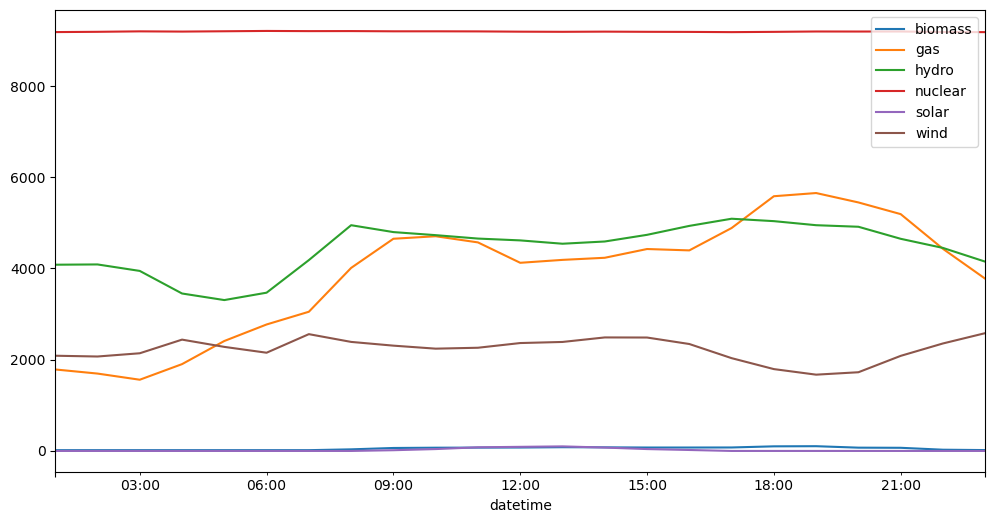

In [163]:
df_output_by_source = pd.DataFrame()
for source in sources:
    df_output_by_source[source] = df_output[plants_by_source[source]].sum(axis=1)
df_output_by_source.plot()

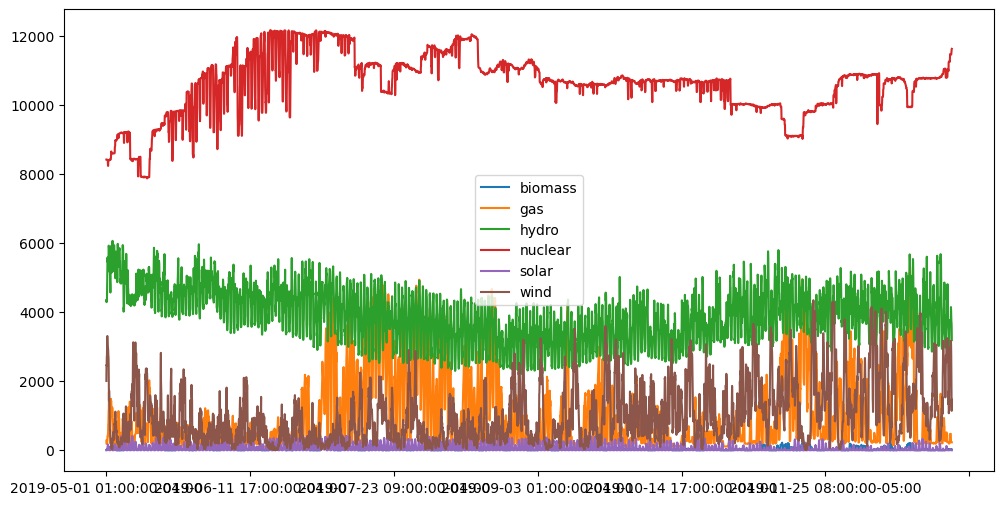

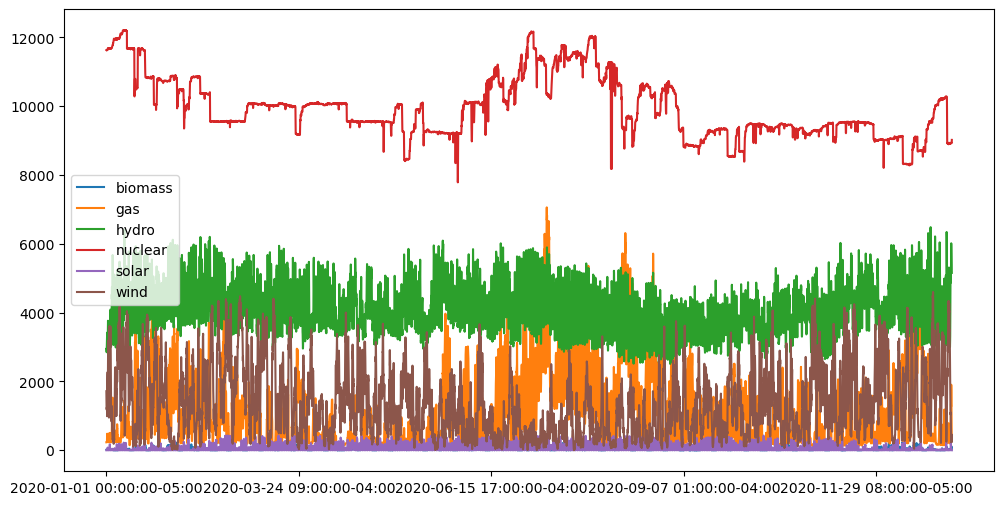

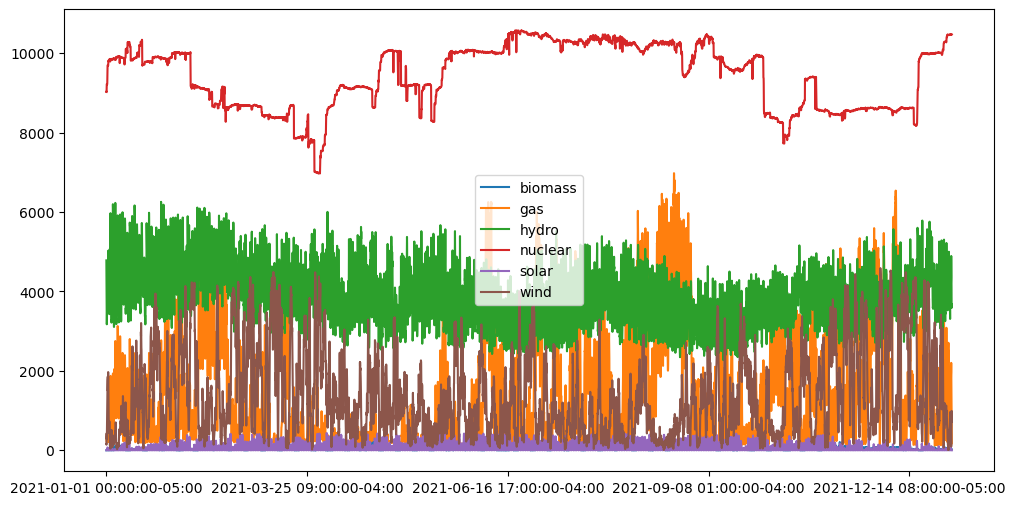

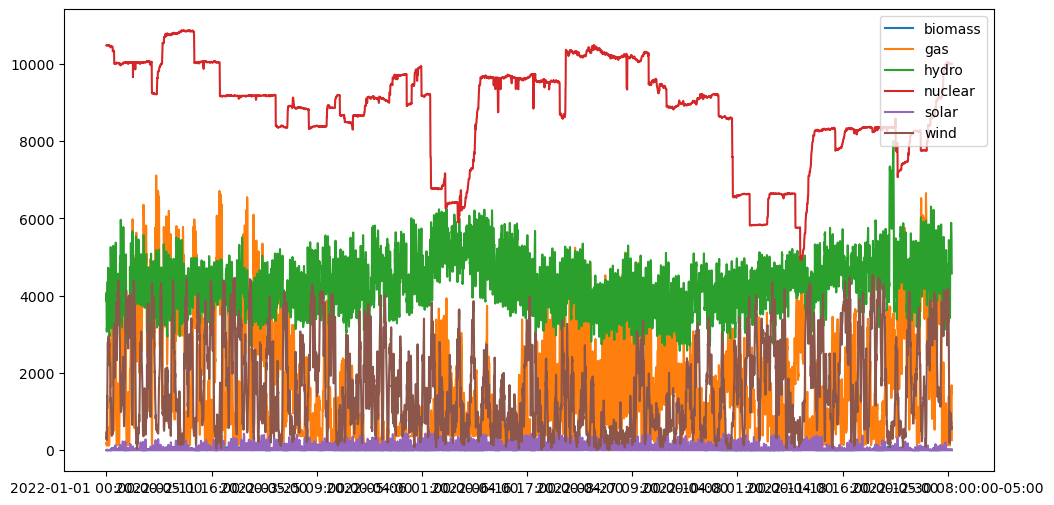

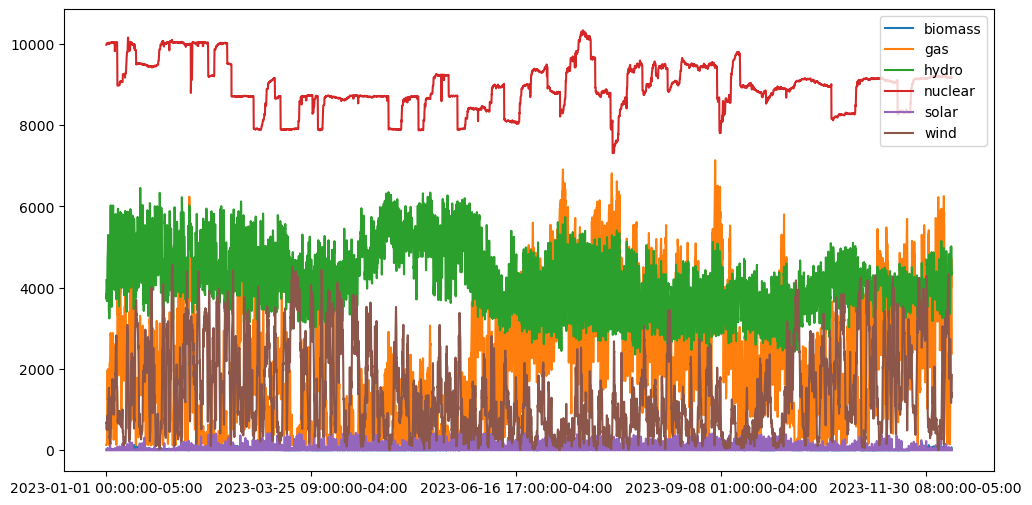

In [210]:
for year in range(2019, 2024):
    csv_filepath = f"https://github.com/ryanfobel/gridwatch-history/blob/main/data/clean/ieso.ca/hourly/output/{year}.csv?raw=true"
    df_output = pd.read_csv(csv_filepath, index_col=0, low_memory=False).replace(" ", 0).astype(float)
    df_output_by_source = pd.DataFrame()
    for source in sources:
        df_output_by_source[source] = df_output[plants_by_source[source]].sum(axis=1)
    df_output_by_source.plot()

![biomass](../images/co2signal.com/biomass.png)
![coal](../images/co2signal.com/coal.png)
![gas](../images/co2signal.com/gas.png)
![geothermal](../images/co2signal.com/geothermal.png)
![hydro](../images/co2signal.com/hydro.png)
![nuclear](../images/co2signal.com/nuclear.png)
![oil](../images/co2signal.com/oil.png)
![solar](../images/co2signal.com/solar.png)
![wind](../images/co2signal.com/wind.png)

In [55]:
df_intensity = pd.DataFrame({
    "biomass": {
        "carbon_intensity": 230,
        "source": "IPCC 2014"
    },
    "coal": {
        "carbon_intensity": 820,
        "source": "IPCC 2014"
    },
    "gas": {
        "carbon_intensity": 490,
        "source": "IPCC 2014"
    },
    "geothermal": {
        "carbon_intensity": 38,
        "source": "IPCC 2014"
    },
    "hydro": {
        "carbon_intensity": 24,
        "source": "IPCC 2014"
    },
    "nuclear": {
        "carbon_intensity": 5,
        "source": "Mallia, E., Lewis, G. 'Life cycle greenhouse gas emissions of electricity generation in the province of Ontario, Canada' (2013)"
    },
    "oil": {
        "carbon_intensity": 650,
        "source": "UK POST 2014"
    },
    "solar": {
        "carbon_intensity": 45,
        "source": "IPCC 2014"
    },
    "wind": {
        "carbon_intensity": 11,
        "source": "IPCC 2014"
    },
})
df_intensity

,biomass,coal,gas,geothermal,hydro,nuclear,oil,solar,wind
carbon_intensity,230,820,490,38,24,5,650,45,11
source,IPCC 2014,IPCC 2014,IPCC 2014,IPCC 2014,IPCC 2014,"Mallia, E., Lewis, G. 'Life cycle greenhouse g...",UK POST 2014,IPCC 2014,IPCC 2014


In [56]:
sources = [col[len("production."):] for col in df.columns if col.startswith("production.")]

df["production.total"] = 0
for source in sources:
    df["production.total"] = df["production.total"] + df[f"production.{source}"]

df["emissions.total"] = 0
for source in sources:
    df[f"emissions.{source}"] = df[f"production.{source}"] * df_intensity[source].carbon_intensity
    df["emissions.total"] = df["emissions.total"] + df[f"emissions.{source}"]
df

,name,fuel,dt,production,production.total,emissions.total
0,BRUCEA-G1,nuclear,2023-09-11 01:00:00-05:00,0.0,0,0
1,BRUCEA-G1,nuclear,2023-09-11 02:00:00-05:00,0.0,0,0
2,BRUCEA-G1,nuclear,2023-09-11 03:00:00-05:00,0.0,0,0
3,BRUCEA-G1,nuclear,2023-09-11 04:00:00-05:00,0.0,0,0
4,BRUCEA-G1,nuclear,2023-09-11 05:00:00-05:00,0.0,0,0
...,...,...,...,...,...,...
4315,TBAYBOWATER CTS,biomass,2023-09-11 20:00:00-05:00,1.0,0,0
4316,TBAYBOWATER CTS,biomass,2023-09-11 21:00:00-05:00,0.0,0,0
4317,TBAYBOWATER CTS,biomass,2023-09-11 22:00:00-05:00,0.0,0,0
4318,TBAYBOWATER CTS,biomass,2023-09-11 23:00:00-05:00,0.0,0,0


In [13]:
df["carbon_intensity"] = df["emissions.total"] / df["production.total"] # kg/MWh or g/kWh

# production in MW, emissions in kg CO2e, carbon intensity (gCO2e/kWh)
df[["production.total", "emissions.total", "carbon_intensity"]]

,production.total,emissions.total,carbon_intensity
0,0,0,NaN
1,0,0,NaN
2,0,0,NaN
3,0,0,NaN
4,0,0,NaN
5,0,0,NaN
6,0,0,NaN
7,0,0,NaN
8,0,0,NaN
9,0,0,NaN
